In [1]:
import numpy as np
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from pytorchtools import EarlyStopping #from https://github.com/Bjarten/early-stopping-pytorch
import time

In [2]:
#set random seed
random_seed = 100 
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(random_seed)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.fc1 = nn.Linear(9216, 2000)
        self.fc2 = nn.Linear(2000, 200)
        self.fc3 = nn.Linear(200, 10)

    def forward(self, x):
        
        x = self.conv1(x)
        x = F.relu(x)

        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = self.fc3(x)
        output = F.log_softmax(x, dim=1)
        
        return output


def train(args, model, device, train_loader, optimizer, epoch):
    train_loss_total = 0
    correct = 0
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        train_loss_total += output.shape[0] * loss.item()
        pred = output.argmax(dim=1, keepdim=True)  
        correct += pred.eq(target.view_as(pred)).sum().item()
    train_loss_epoch = train_loss_total / len(train_loader.dataset)
    print('Train set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)'.format(
        train_loss_epoch, correct, len(train_loader.dataset),
        100. * correct / len(train_loader.dataset)))
    return train_loss_epoch,100. * correct / len(train_loader.dataset)


def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item() 
            pred = output.argmax(dim=1, keepdim=True)  
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    return test_loss, 100. * correct / len(test_loader.dataset)


In [4]:
# Training settings
parser = argparse.ArgumentParser(description='PyTorch MNIST')
parser.add_argument('--batch-size', type=int, default=64, metavar='N',
                    help='input batch size for training')
parser.add_argument('--test-batch-size', type=int, default=1000, metavar='N',
                    help='input batch size for testing (default: 1000)')
parser.add_argument('--epochs', type=int, default=200, metavar='N',
                    help='number of epochs to train)')
parser.add_argument('--lr', type=float, default=1e-5, metavar='LR',
                    help='learning rate')
parser.add_argument('--log-interval', type=int, default=10, metavar='N',
                    help='how many batches to wait before logging training status')
parser.add_argument('--early_stopping', default=True,
                    help='Whether to do early stopping')
args,unknown = parser.parse_known_args()

In [5]:
from datetime import datetime

train_kwargs = {'batch_size': args.batch_size}
test_kwargs = {'batch_size': args.test_batch_size}

cuda_kwargs = {'num_workers': 2,
               'pin_memory': True,
               'shuffle': True}
train_kwargs.update(cuda_kwargs)
test_kwargs.update(cuda_kwargs)

transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
    ])
dataset1 = datasets.MNIST('../data', train=True, download=True,
                   transform=transform)
dataset2 = datasets.MNIST('../data', train=False,download=True,
                   transform=transform)
train_loader = torch.utils.data.DataLoader(dataset1,**train_kwargs)
test_loader = torch.utils.data.DataLoader(dataset2, **test_kwargs)


model = Net()

# if torch.cuda.device_count() > 1:
#     print("Let's use", torch.cuda.device_count(), "GPUs!")
#     model = nn.DataParallel(model)
    
model.to(device)

optimizer = optim.Adam(model.parameters(), lr=args.lr, betas=(0.99, 0.9999))
#optimizer = optim.SGD(model.parameters(), lr=args.lr)


train_loss = []
test_loss = []
train_acc = []
test_acc = []

early_stopping = EarlyStopping(patience=8, verbose=True)

for epoch in range(1, args.epochs + 1):
    
    start = datetime.now()
    print(f"Epoch {epoch}")
    tr_loss,tr_acc = train(args, model, device, train_loader, optimizer, epoch)
    train_loss.append(tr_loss)
    train_acc.append(tr_acc)
    te_loss,te_acc = test(model, device, test_loader)
    test_loss.append(te_loss)
    test_acc.append(te_acc)
    elapsed_time =  datetime.now() - start
    print(f"{elapsed_time.total_seconds()} seconds")

    if args.early_stopping:
        early_stopping(te_loss, model)

        if early_stopping.early_stop:
            print("Early stopping")
            break

    # load the last checkpoint with the best model
if args.early_stopping:
    model.load_state_dict(torch.load('checkpoint.pt'))



Epoch 1


/groups/spruston/home/sunw2/anaconda3/envs/vr2pai/lib/python3.7/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Train set: Average loss: 0.5967, Accuracy: 51750/60000 (86%)
Test set: Average loss: 0.2290, Accuracy: 9336/10000 (93%)
11.500785 seconds
Validation loss decreased (inf --> 0.229030).  Saving model ...
Epoch 2
Train set: Average loss: 0.1939, Accuracy: 56634/60000 (94%)
Test set: Average loss: 0.1475, Accuracy: 9599/10000 (96%)
9.397948 seconds
Validation loss decreased (0.229030 --> 0.147476).  Saving model ...
Epoch 3
Train set: Average loss: 0.1300, Accuracy: 57762/60000 (96%)
Test set: Average loss: 0.1066, Accuracy: 9695/10000 (97%)
9.456356 seconds
Validation loss decreased (0.147476 --> 0.106587).  Saving model ...
Epoch 4
Train set: Average loss: 0.0975, Accuracy: 58342/60000 (97%)
Test set: Average loss: 0.0824, Accuracy: 9760/10000 (98%)
9.420946 seconds
Validation loss decreased (0.106587 --> 0.082433).  Saving model ...
Epoch 5
Train set: Average loss: 0.0779, Accuracy: 58678/60000 (98%)
Test set: Average loss: 0.0696, Accuracy: 9794/10000 (98%)
9.605511 seconds
Validation 


Bad key "text.kerning_factor" on line 4 in
/groups/spruston/home/sunw2/anaconda3/envs/vr2pai/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


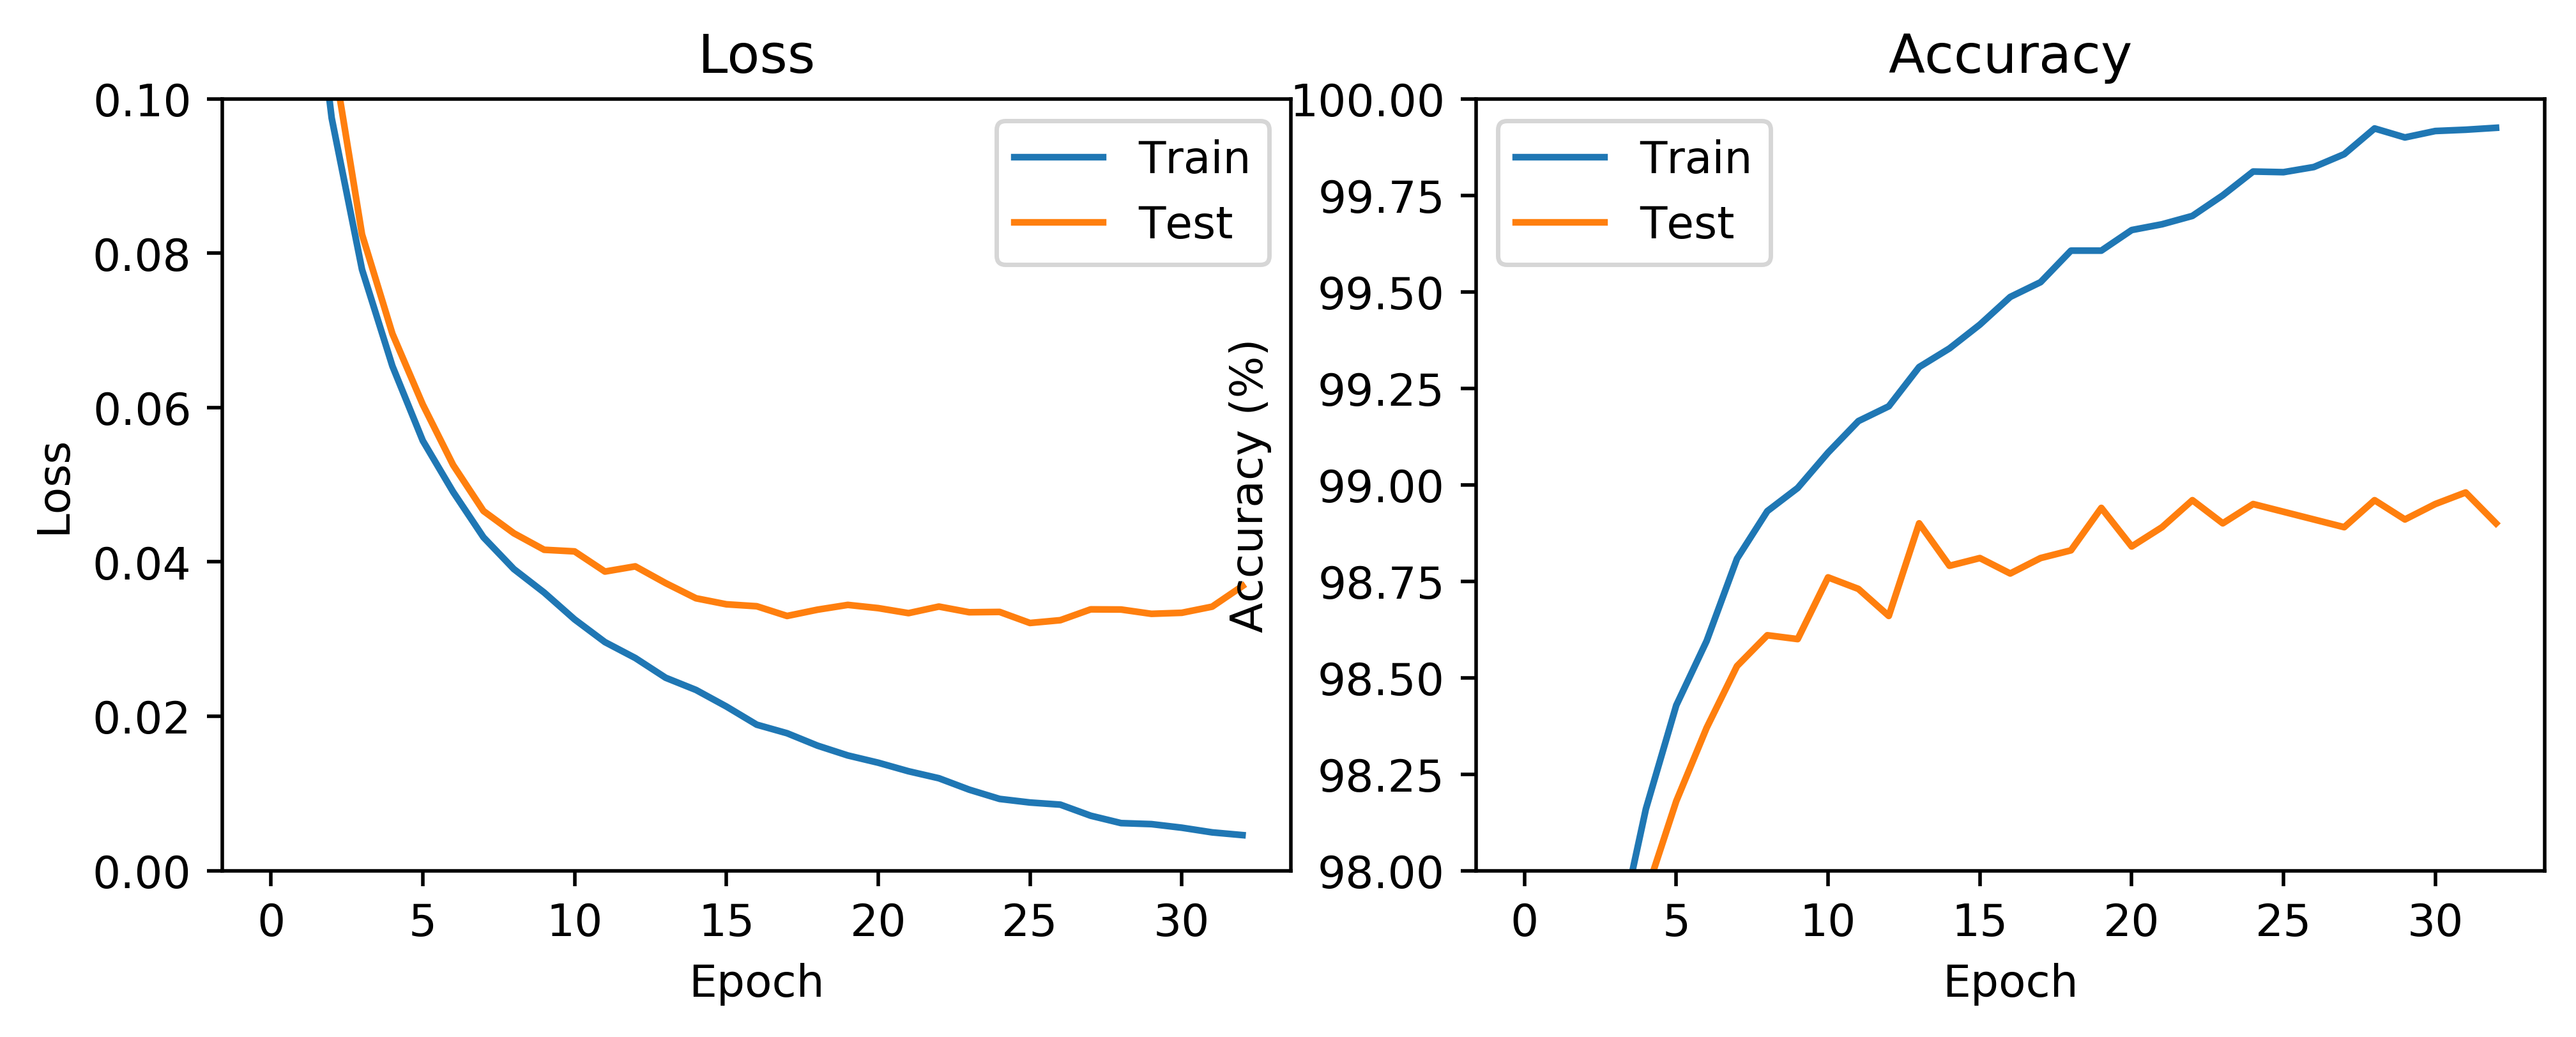

In [6]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2,figsize = (8,3),dpi =500)
fig.tight_layout() 
axs[0].plot(train_loss[1:],label = 'Train')
axs[0].plot(test_loss[:-1],label = 'Test')
axs[0].set_title('Loss')
axs[0].set_ylim(0,0.1)
#axs[0].set_xlim(0,200)

axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].legend()
axs[1].plot(train_acc[1:],label = 'Train')
axs[1].plot(test_acc[:-1],label = 'Test')
#axs[1].set_xlim(0,200)
axs[1].set_ylim(98,100)
axs[1].set_title('Accuracy')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Accuracy (%)')
axs[1].legend()




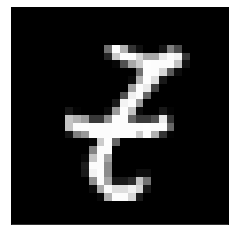

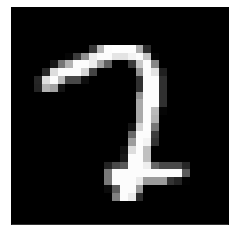

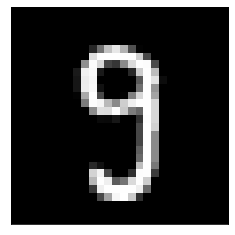

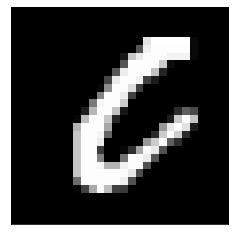

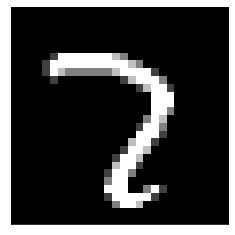

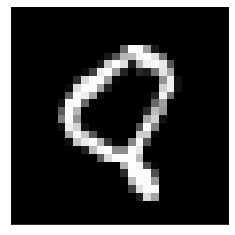

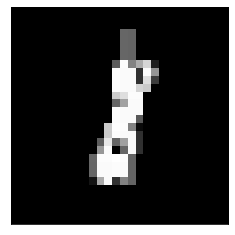

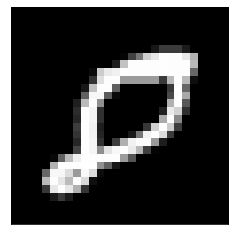

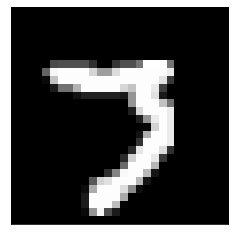

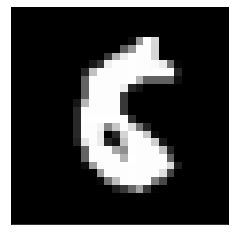

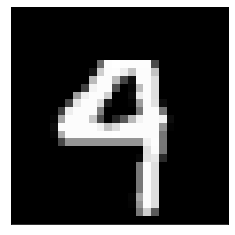

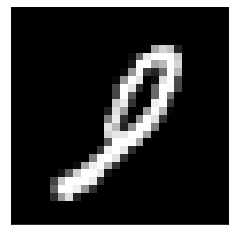

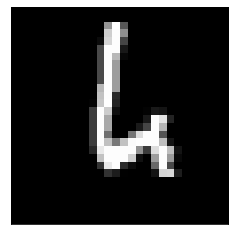

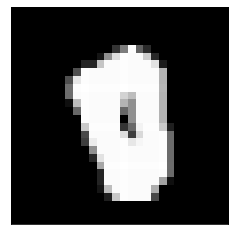

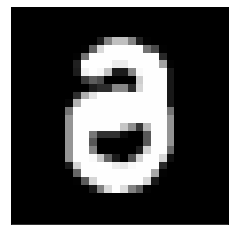

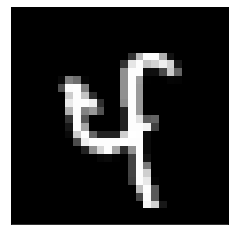

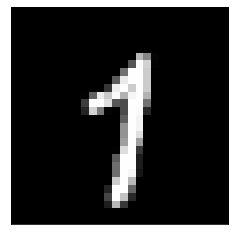

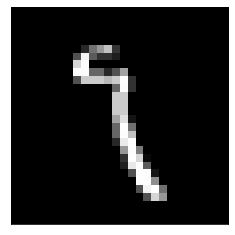

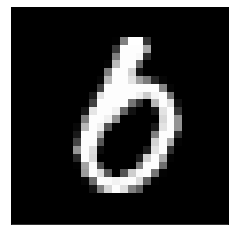

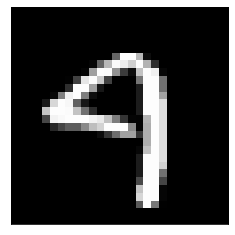

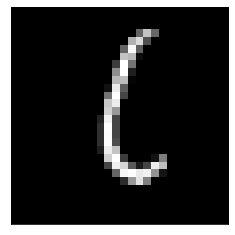

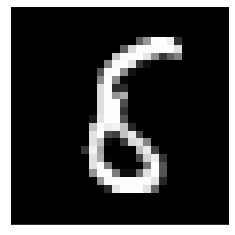

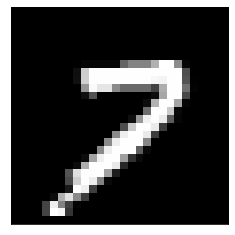

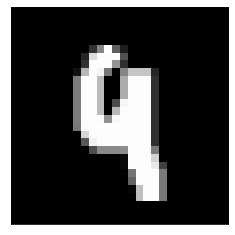

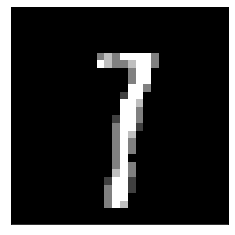

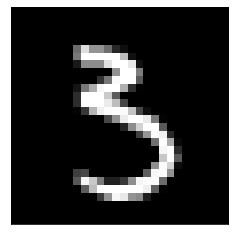

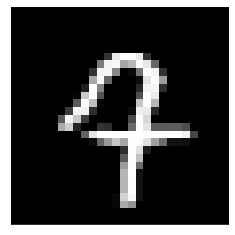

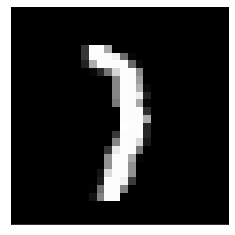

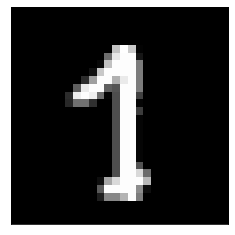

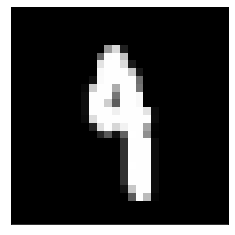

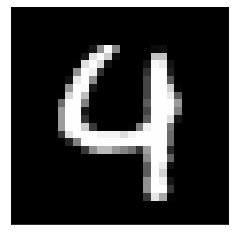

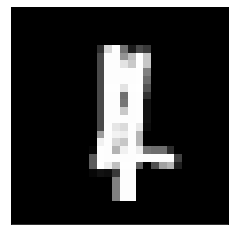

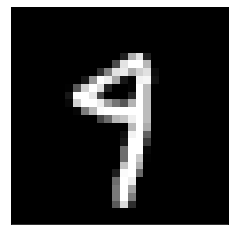

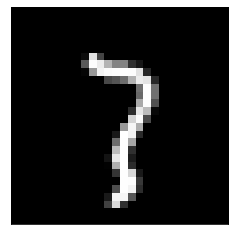

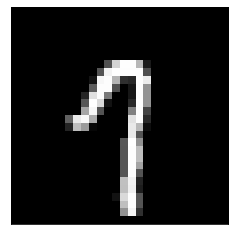

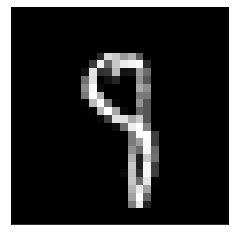

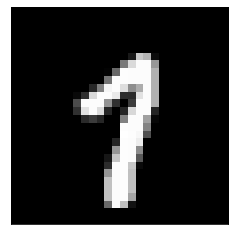

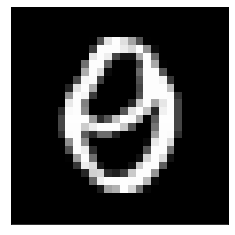

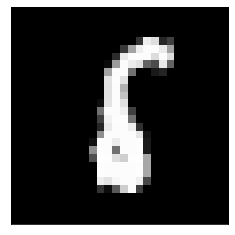

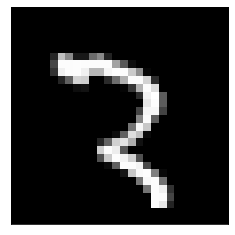

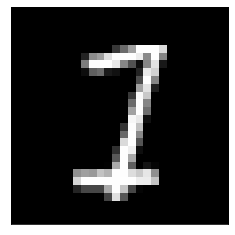

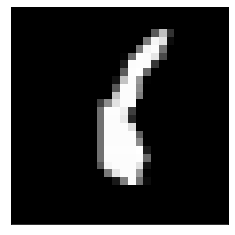

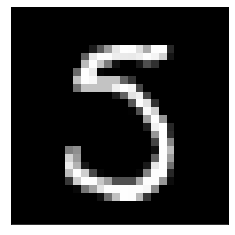

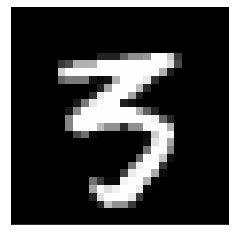

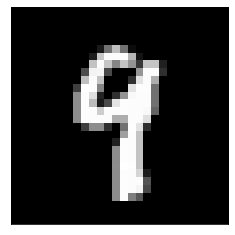

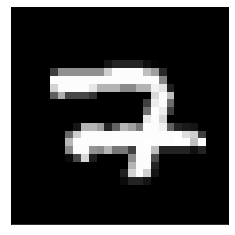

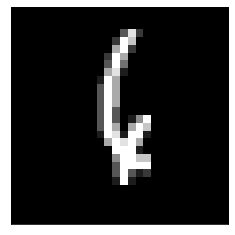

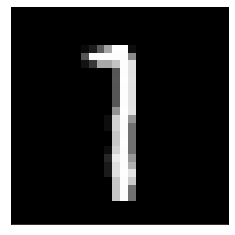

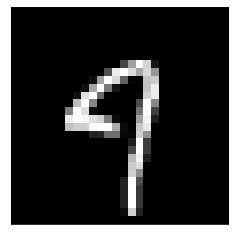

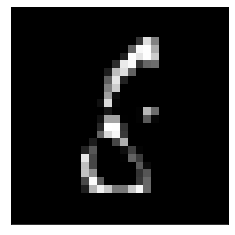

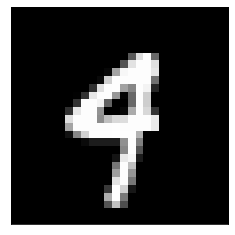

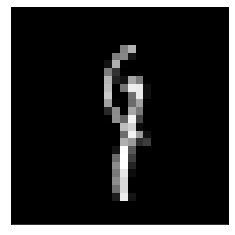

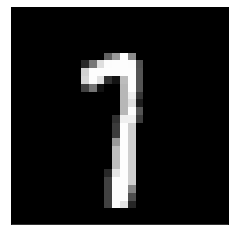

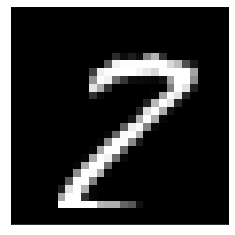

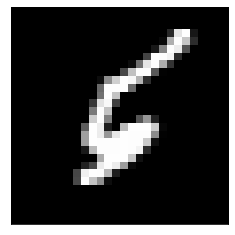

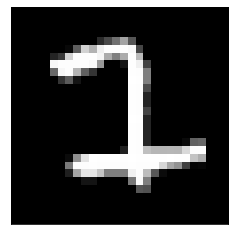

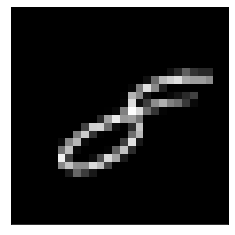

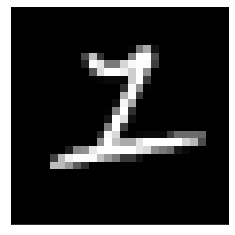

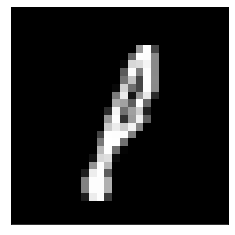

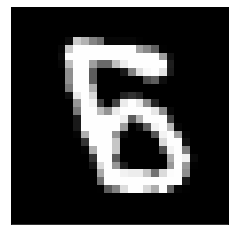

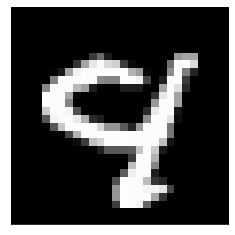

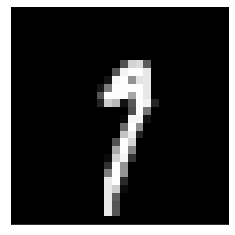

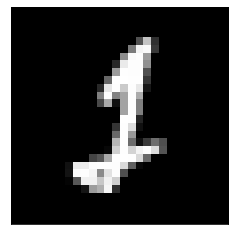

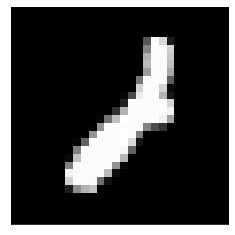

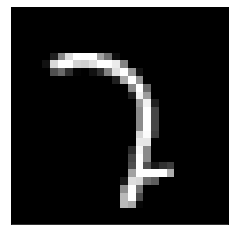

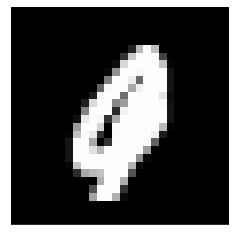

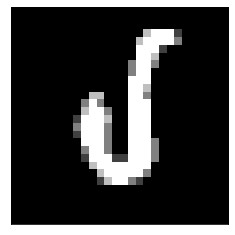

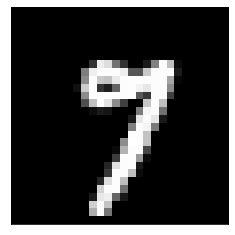

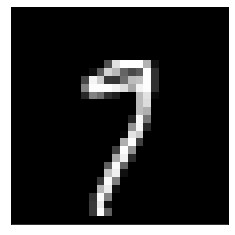

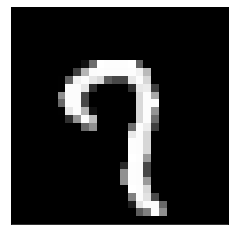

In [8]:
#find non-memorized training data 
model.eval()
with torch.no_grad():
    for data, target in train_loader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        pred = output.argmax(dim=1, keepdim=True)  
        if (~pred.eq(target.view_as(pred))).sum().item() > 0:
            for i in np.where(np.squeeze((~pred.eq(target.view_as(pred))).cpu()))[0]:
                plt.figure()
                plt.imshow(np.squeeze(data[i].cpu()),aspect = 1,cmap = 'gray')
                frame = plt.gca()
                frame.axes.get_xaxis().set_visible(False)
                frame.axes.get_yaxis().set_visible(False)
                plt.show()
        


